**Boston Airbnb**¶


In [ ]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


%matplotlib inline

In [ ]:
# Import data
url1= 'https://raw.githubusercontent.com/Mikemraz/boston-airbnb-analysis/master/calendar.csv'
url2= 'https://raw.githubusercontent.com/Mikemraz/boston-airbnb-analysis/master/reviews.csv'
url3='https://raw.githubusercontent.com/Mikemraz/boston-airbnb-analysis/master/listings.csv'


df_calendar = pd.read_csv(url1)
df_reviews = pd.read_csv(url2)
df_listings = pd.read_csv(url3)


**Business Understanding**

1. What are the most common listings
2. What type of property has higher listing price?
3. What is the price distribution?
4. What features correlate with price?
5. What's important to tenants


**Data Preparation**


In [ ]:
df_reviews.head(3)

In [ ]:
df_listings.head(3)

In [ ]:
df_listings.describe()


In [ ]:
df_listings.columns

Data Quality Issues to be fixed:
- fixing object type
- removing columns with majority of missing data
- removing rows for bedroom, bathroom, accomodates where value is zero
- for some columns complete NA values with mean

In [ ]:
# Missing values
missing_values = df_listings.isnull().sum()
percent_missing_values = (missing_values/len(df_listings))*100
percent_missing_values.sort_values(ascending=False)

In [ ]:
# Droping columns with majority missing values
outliers_columns=percent_missing_values[percent_missing_values>80]
outliers_columns

In [ ]:
df_listings = df_listings.drop(['neighbourhood_group_cleansed',
 'square_feet',
 'has_availability',
 'license',
 'jurisdiction_names'], axis=1)

In [ ]:
# format price column
df_listings.price = df_listings.price.str.lstrip('$').str.replace(',', '').astype('float')


In [ ]:
# Drop rows with price <= 0, bathrooms < 1, bedrooms <=0, accommodates <= 0
df_listings = df_listings[df_listings.price > 0]
df_listings = df_listings[df_listings.bathrooms >= 1]
df_listings = df_listings[df_listings.bedrooms > 0]
df_listings = df_listings[df_listings.accommodates > 0]


In [ ]:
# Convert number of bathrooms, bedrooms, accommodates to int
df_listings.bathrooms = df_listings.bathrooms.astype('int')
df_listings.bedrooms = df_listings.bedrooms.astype('int')
df_listings.accommodates = df_listings.accommodates.astype('int')


In [ ]:
# extract the number of amenities 
df_listings['n_amenities'] = df_listings['amenities'].apply(lambda x: len(x.replace('{', '').\
                        replace('{', '').replace('"', '').split(',')))
df_listings.drop('amenities', axis=1, inplace=True)

In [ ]:
# Subtrack numberical columns  for correlation and drop unused columns

listings_num = df_listings.select_dtypes(include=['int', 'float'])


listings_num = listings_num.drop(['host_listings_count', 'host_total_listings_count', 'id', 'scrape_id', 'host_id', 'latitude', 'longitude', 'reviews_per_month'], axis=1)


In [ ]:
# Fill null values with mean and convert values to int
cols = ['n_amenities', 'beds', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
for col in cols:
    listings_num[col].fillna(value=listings_num[col].mean(), inplace=True)

for col in cols:
    listings_num[col] = listings_num[col].astype('float64').astype('int64')
listings_num[cols].dtypes

**Data Exploration**

**1) What are the most common listings**

In [ ]:
df_listings.neighbourhood_cleansed.value_counts()

df_listings.neighbourhood_cleansed.value_counts().plot.bar(title = 'Neighbourhood Distribution', figsize = (8,8))
plt.xlabel('Neighbourhood');
plt.ylabel('Number of listings');
plt.savefig("fig1.png", bbox_inches = 'tight') # save as png


In [ ]:
df_listings.property_type.value_counts().plot.bar(title = 'Property Type Distribution', figsize = (8,8))
plt.xlabel('Property type');
plt.ylabel('Number of listings');
plt.savefig("fig2.png", bbox_inches = 'tight') # save as png

In [ ]:
plt.hist(df_listings['bathrooms'])
plt.xlabel('No of Bedrooms');
plt.ylabel('Number of listings');
plt.savefig("fig3.png", bbox_inches = 'tight') # save as png

The most common listings are for one bedroom apartments. Most properties are in Jamaica Plain and the least in Leather District.

**2) What type of property has higher listing price?**

In [ ]:
def heatmap_for_price(col_list):
    '''
    This function creates heatmap of price against given combinations of features
    
    INPUT
    col_list - list of columns against which price heatmap is to be generated
    
    OUTPUT
    plt: heatmap of given size and title
    
    '''
    plt.figure(figsize=(12,12))
    sns.heatmap(df_listings.groupby(col_list).price.mean().unstack(),annot=True, fmt=".2f");
    plt.title('Price heatmap by {}'.format(col_list))

In [ ]:
heatmap_for_price(['property_type', 'room_type'])
plt.savefig("fig4.png", bbox_inches = 'tight') # save as png

In [ ]:
heatmap_for_price(['neighbourhood_cleansed','room_type'])
plt.savefig("fig5.png", bbox_inches = 'tight') # save as png

Highest average price lies with townhouse when renting the whole property and interestingly with boar where private room can be rented. When it comes to the neighbourhood, the most expensive one is South Boston Waterfront followed by Bay Village. However, it has to be noted that most expensive locations are not where majority of listings are. Jamaica Plain with one bedroom, which was the location with the most listings is on lower scale of average prices.

In [ ]:
# Most expensive street
price_by_street = df_listings.groupby('street').price.mean()
price_by_street.sort_values(ascending=False).head(1)


**3) What is the price distribution?**

In [ ]:
# visualizae the price
plt.figure(figsize=(8, 6))
sns.distplot(listings_num['price'], bins=50, kde=True)
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Price (dollar)', fontsize=12)
plt.title('Listed Price Distribution', fontsize=14)
plt.savefig("fig6.png", bbox_inches = 'tight') # save as png;

In [ ]:
plt.figure(figsize=(16, 10));
listings_num[listings_num['price'] < 430]['price'].hist(bins=80); # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html
plt.title('Price of listings', size = 20,  color='C5');
plt.ylabel('No of listings', size =16, color='C5');
plt.xlabel('Price (USD)', size = 2, color='C5');
plt.savefig("fig7.png", bbox_inches = 'tight') # save as png;

In [ ]:
listings_num['price'].mean()


In [ ]:
listings_num['price'].median()


We can see that there are some locations with extremely high or low price, however typical price for a property is around £150.

**4) What correlates with a price?**

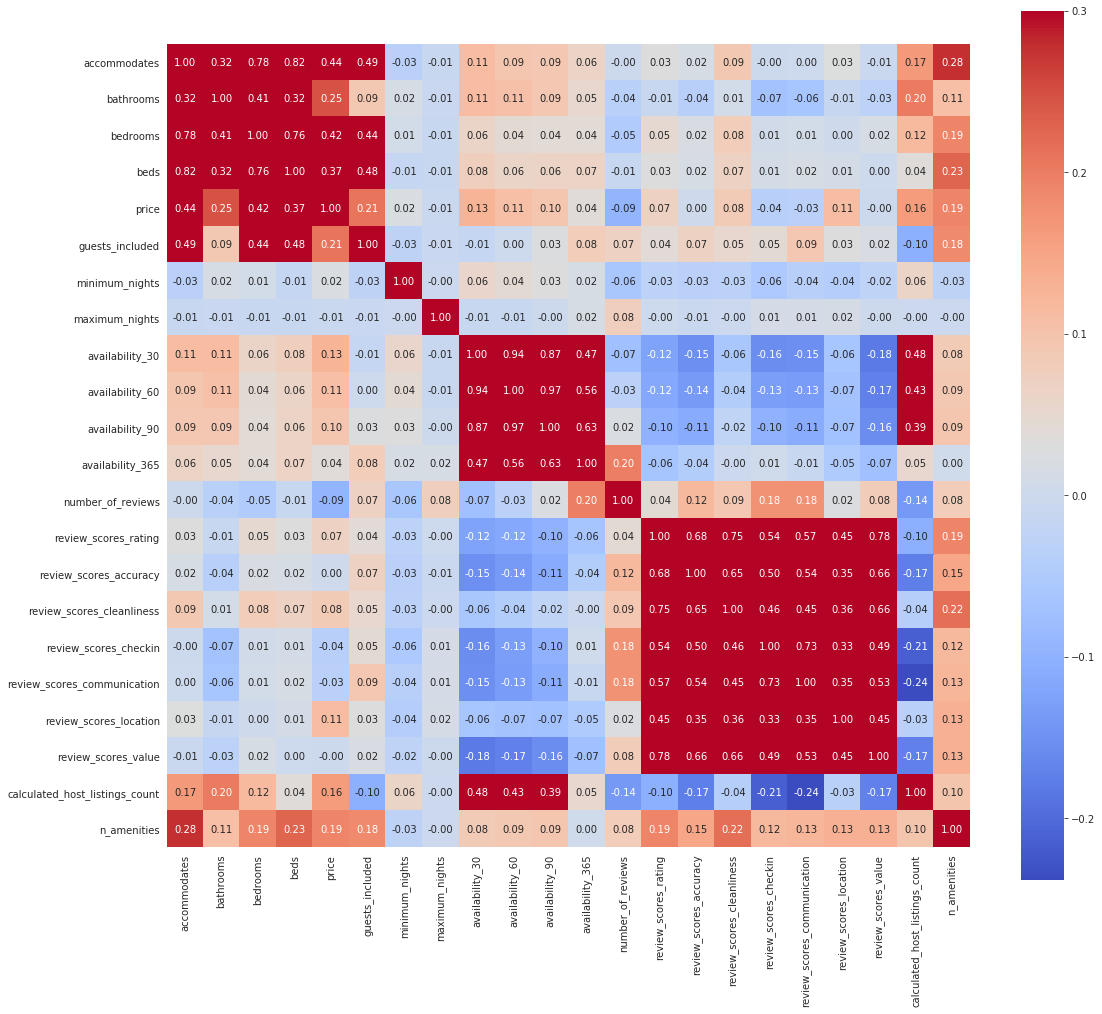

In [27]:
# visualize the correlation matrix
corr = listings_num.corr()
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(18, 16))
    ax = sns.heatmap(corr, vmax=.3, square=True, annot=True, fmt='.2f', cmap='coolwarm')
    plt.savefig("fig8.png", bbox_inches = 'tight') # save as png;

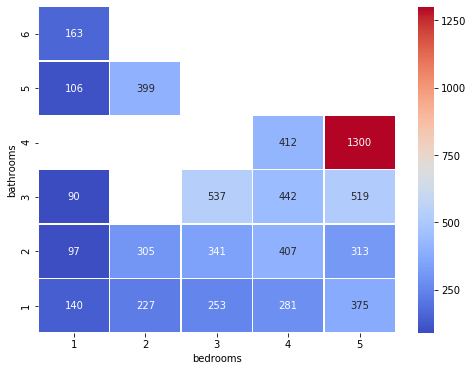

In [28]:
# Average price based on no of bedrooms and bathrooms
plt.figure(figsize=(8, 6))
sns.heatmap(listings_num.groupby(['bathrooms', 'bedrooms']).mean()['price'].reset_index()\
                .pivot('bathrooms', 'bedrooms', 'price').sort_index(ascending=False),
            cmap="coolwarm", fmt='.0f', annot=True, linewidths=0.5);
plt.savefig("fig9.png", bbox_inches = 'tight') # save as png;

It's probably no surprise that what correlates with the price is the size of the property defined by no of bedroom, bathroom and accomodates. When looking at average prices based on no of bathrooms and bedrooms there is high price for a property with 3 bedrooms and 3 bathrooms. It's also interesting that having a property with 2 or 3 bedrooms and 1 bedroom doesn't make a big difference in renting price.

**5) Features that matters**

In [29]:
# Define a function to generate wordcloud.
from functools import reduce
def generate_wordcould(text_list):
    """generate and visulize a text vector that in list-like form
    
       INPUT
       text_list - a list of strings
       OUTPUT
       plt - a plot showing text occurances (text size is directly proportional to frequency)
    """
    text = reduce((lambda x, y: x+y), text_list)
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

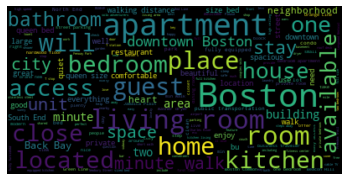

In [30]:
# Get vocabulary of reviews from house descriptions.
generate_wordcould(df_listings['description'])


In [31]:
# get vocabulary of reviews from df_reviews
reviews = df_reviews[df_reviews['comments'].notnull()]


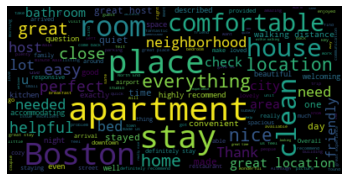

In [33]:
generate_wordcould(reviews['comments'])

Among other things, home owners emphasize room types, property types, neighborhood, bed sizes, comfort and distance proximity while tenants comment in their reviews about the host, location and cleanliness.